In [9]:
import pickle
import pickletools
import utils
import matplotlib.pyplot as plt
import numpy as np 
from scipy.stats import t

# Single Data

In [2]:
with open('./graph_datadata_object.pkl', 'rb') as inp:
    data = pickle.load(inp)

In [3]:
# Collect UE's data handover from the satellite 1
sat_id = 1
res = {}
count = 0
for ue_id in data.UE_time_stamp:
    UE_time = data.UE_time_stamp[ue_id]
    for each in UE_time:
        if each['from'] == sat_id:
            if ue_id not in res:
                res[ue_id] = []
            else:
                count += 1
            res[ue_id].append(each)
print(f"{count} UEs switched from Group handover to Single handover")

2461 UEs switched from Group handover to Single handover


In [4]:
res_success_or_failure = {}
res_waiting_time = {}
res_waiting_time_group = {}
res_waiting_time_non_group = {}

res_waiting_time_group_timeout = {}
res_waiting_time_group_nontimeout = {}


res_alpha = {}

waiting_time_success = []
waiting_time_failure = []

waiting_time_success_group = []
waiting_time_failure_group = []

waiting_time_success_non_group = []
waiting_time_failure_non_group = []


for id in res:
    r = res[id]
    if len(r) == 2:
        waiting_time = r[1]['timestamp'][-1] - r[0]['timestamp'][0]
        success = r[1]['isSuccess']
        res_waiting_time_group[id] = waiting_time
        res_waiting_time_group_timeout[id] = waiting_time
    elif len(r) == 1:
        waiting_time = r[0]['timestamp'][-1] - r[0]['timestamp'][0]
        if 'group' in r[0]:
            res_waiting_time_group[id] = waiting_time
            res_waiting_time_group_nontimeout[id] = waiting_time
        else:
            res_waiting_time_non_group[id] = waiting_time
        success = r[0]['isSuccess']
    else:
        print("ERROR")
    res_waiting_time[id] =  waiting_time
    res_success_or_failure[id] = success

def separate_waiting_time(result_waiting_time, result_success_or_failure):
    result_waiting_time_success = []
    result_waiting_time_failure = []
    for id in result_waiting_time:
        if result_success_or_failure[id]:
            result_waiting_time_success.append(result_waiting_time[id])
        else:
            result_waiting_time_failure.append(result_waiting_time[id])
    return result_waiting_time_success, result_waiting_time_failure

waiting_time_success, waiting_time_failure = separate_waiting_time(res_waiting_time, res_success_or_failure)
waiting_time_success_group, waiting_time_failure_group = separate_waiting_time(res_waiting_time_group, res_success_or_failure)
waiting_time_success_non_group, waiting_time_failure_non_group = separate_waiting_time(res_waiting_time_non_group, res_success_or_failure)
waiting_time_success_group_timeout, waiting_time_failure_group_timeout = separate_waiting_time(res_waiting_time_group_timeout, res_success_or_failure)
waiting_time_success_group_nontimeout, waiting_time_failure_group_nontimeout = separate_waiting_time(res_waiting_time_group_nontimeout, res_success_or_failure)



# Draw with alpha

In [5]:
res_alpha = {}

def determine_range(value, min_value, max_value, num_ranges):
    if value < min_value or value > max_value:
        return None  # Value is outside the specified range

    range_size = (max_value - min_value) / num_ranges
    range_index = int((value - min_value) / range_size)

    return range_index
    
log_waiting_time_success = np.log(np.array(waiting_time_success) + 1)
log_waiting_time_failure = np.log(np.array(waiting_time_failure) + 1)

num_range = 10
alpha_values = np.linspace(0.1, 1.0, num_range)
if len(waiting_time_success)!= 0: min_value_success = min(log_waiting_time_success)
if len(waiting_time_success)!= 0: max_value_success = max(log_waiting_time_success)
if len(waiting_time_failure)!= 0: min_value_failure = min(log_waiting_time_failure)
if len(waiting_time_failure)!= 0: max_value_failure = max(log_waiting_time_failure)
for id in res:
    if res_success_or_failure[id]:
        range_index = determine_range(np.log(res_waiting_time[id] + 1), min_value_success, max_value_success+1, num_range)
    else:
        range_index = determine_range(np.log(res_waiting_time[id] + 1), min_value_failure, max_value_failure+1, num_range)
    res_alpha[id] = alpha_values[range_index]

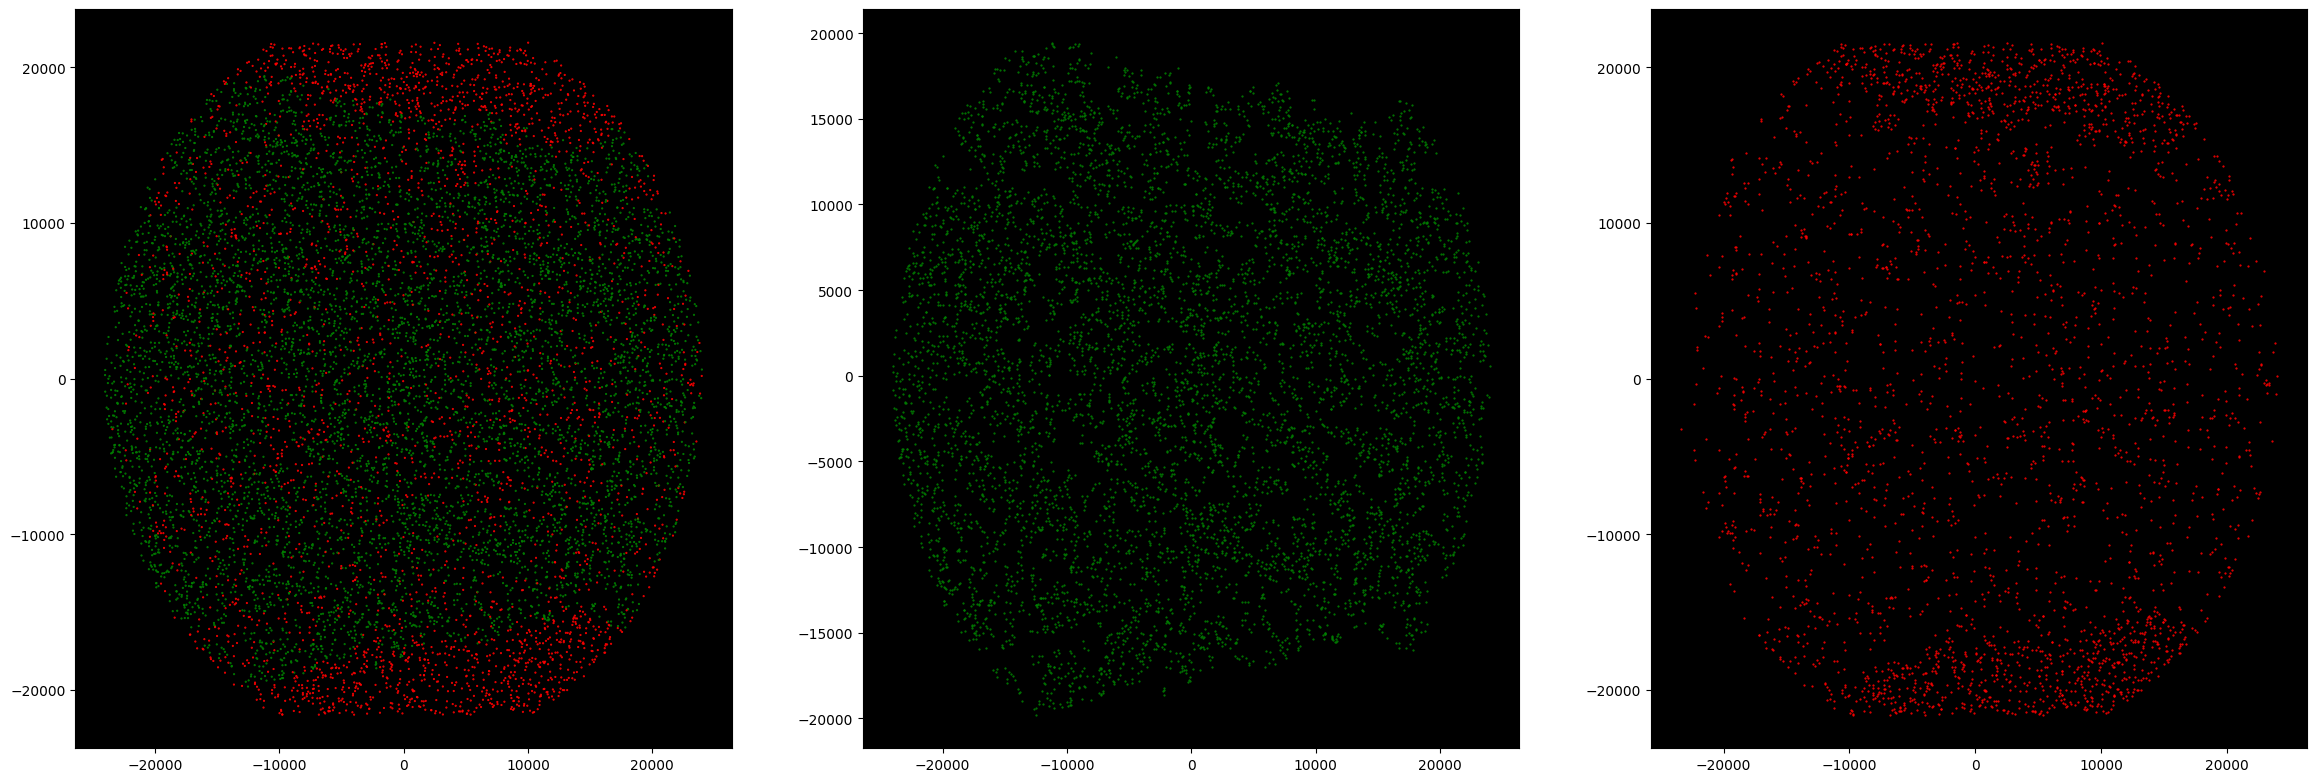

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(36*0.8, 12*0.8))
size = 0.3

UE_positions = data.UE_positions
pop_keys = []
for id in UE_positions:
    if id not in res:
        pop_keys.append(id)
for key in pop_keys:
    UE_positions.pop(key)
    
# Combined Graph
pos_x = np.array([UE_positions[id][0] for id in UE_positions])
pos_y = np.array([UE_positions[id][1] for id in UE_positions])
res_success_or_failure_array = np.array([res_success_or_failure[id] for id in UE_positions])
colors = np.where(res_success_or_failure_array, 'g', 'red')
alpha = np.array([res_alpha[id] for id in UE_positions])
axes[0].scatter(x=pos_x, y=pos_y, c=colors, alpha=1, s = size)
axes[0].set_facecolor("black")

# Success
success_UE_positions = {}
for id in UE_positions:
    if res_success_or_failure[id]:
        success_UE_positions[id] = UE_positions[id]
if len(success_UE_positions) != 0:
    pos_x = np.array([success_UE_positions[id][0] for id in success_UE_positions])
    pos_y = np.array([success_UE_positions[id][1] for id in success_UE_positions])
    alpha = np.array([res_alpha[id] for id in success_UE_positions])
    axes[1].scatter(x=pos_x, y=pos_y, c='g', alpha=1, s = size)
    axes[1].set_facecolor("black")

# Failure
failure_UE_positions = {}
for id in UE_positions:
    if not res_success_or_failure[id]:
        failure_UE_positions[id] = UE_positions[id]
if len(failure_UE_positions) != 0:
    pos_x = np.array([failure_UE_positions[id][0] for id in failure_UE_positions])
    pos_y = np.array([failure_UE_positions[id][1] for id in failure_UE_positions])
    alpha = np.array([res_alpha[id] for id in failure_UE_positions])
    axes[2].scatter(x=pos_x, y=pos_y, c='r', alpha=1, s = size)
    axes[2].set_facecolor("black")

In [12]:
def stat(values, confidence):
    v = np.array(values)
    m = v.mean()
    s = v.std()
    dof = len(v) - 1
    t_crit = np.abs(t.ppf((1-confidence)/2,dof))
    c = (m-s*t_crit/np.sqrt(len(v)), m+s*t_crit/np.sqrt(len(v)))
    print(f"mean: {m}, variance: {s*s}, confidence interval: {c}")

confidence = 0.95

print("Overall: Number of Success: ", len(waiting_time_success))
stat(waiting_time_success, confidence)
print("Overall: Number of Failure: ", len(waiting_time_failure))
stat(waiting_time_failure, confidence)

print("Group: Number of Success: ", len(waiting_time_success_group))
stat(waiting_time_success_group, confidence)
print("Group: Number of Failure: ", len(waiting_time_failure_group))
stat(waiting_time_failure_group, confidence)

print("Timeout Group: Number of Success: ", len(waiting_time_success_group_timeout))
stat(waiting_time_success_group_timeout, confidence)
print("Timeout Group: Number of Failure: ", len(waiting_time_failure_group_timeout))
stat(waiting_time_failure_group_timeout, confidence)

print("Non-Timeout Group: Number of Success: ", len(waiting_time_success_group_nontimeout))
stat(waiting_time_success_group_nontimeout, confidence)
print("Non-Timeout Group: Number of Failure: ", len(waiting_time_failure_group_nontimeout))
stat(waiting_time_failure_group_nontimeout, confidence)

print("Non Group: Number of Success: ", len(waiting_time_success_non_group))
stat(waiting_time_success_non_group, confidence)
print("Non Group: Number of Failure: ", len(waiting_time_failure_non_group))
stat(waiting_time_failure_non_group, confidence)

Overall: Number of Success:  6557
mean: 585.7992679578751, variance: 85671.62869549885, confidence interval: (578.7133813674171, 592.8851545483332)
Overall: Number of Failure:  3082
mean: 993.2537313432836, variance: 266767.44957238465, confidence interval: (975.0118831902989, 1011.4955794962682)
Group: Number of Success:  6429
mean: 594.7439726240156, variance: 82531.4922910003, confidence interval: (587.720239359817, 601.7677058882141)
Group: Number of Failure:  2042
mean: 1043.1939275220373, variance: 217294.87914040216, confidence interval: (1022.9636151165089, 1063.4242399275656)
Timeout Group: Number of Success:  419
mean: 754.0248210023461, variance: 34865.91747459905, confidence interval: (736.0939686150778, 771.9556733896145)
Timeout Group: Number of Failure:  2042
mean: 1043.1939275220373, variance: 217294.87914040216, confidence interval: (1022.9636151165089, 1063.4242399275656)
Non-Timeout Group: Number of Success:  6010
mean: 583.6393677204348, variance: 83962.53661322876,

/var/folders/s1/p_7jy48x2gdb3jjp9p75009w0000gn/T/ipykernel_26980/2069684094.py:3: RuntimeWarning: Mean of empty slice.
  m = v.mean()
/Users/zbh/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/zbh/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/zbh/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/zbh/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


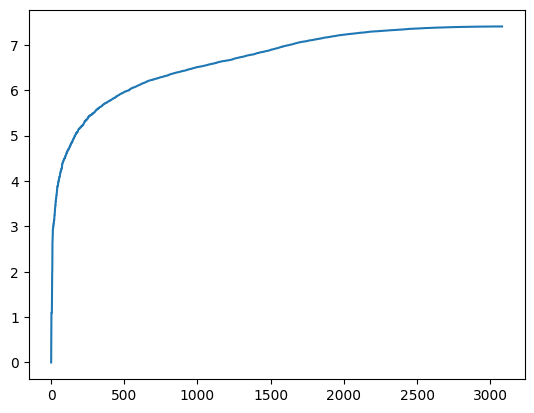

In [21]:
if len(waiting_time_failure) != 0: plt.plot(sorted((waiting_time_failure)))

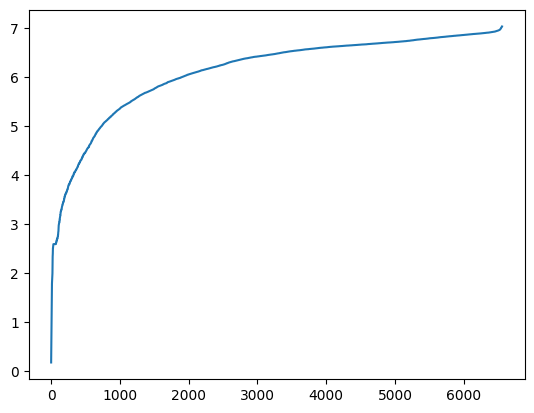

In [22]:
if len(waiting_time_success) != 0: plt.plot(sorted((waiting_time_success)))

In [23]:
#if len(retransmission_number_success) != 0: plt.plot(sorted((retransmission_number_success)))

In [24]:
#if len(retransmission_number_failure) != 0: plt.plot(sorted((retransmission_number_failure)))

# Batch Graph

In [ ]:
with open('./10000/graph_datadata_object.pkl', 'rb') as inp:
    data10000 = pickle.load(inp)
with open('./15000/graph_datadata_object.pkl', 'rb') as inp:
    data15000 = pickle.load(inp)
with open('./20000/graph_datadata_object.pkl', 'rb') as inp:
    data20000 = pickle.load(inp)
with open('./25000/graph_datadata_object.pkl', 'rb') as inp:
    data25000 = pickle.load(inp)
with open('./30000/graph_datadata_object.pkl', 'rb') as inp:
    data30000 = pickle.load(inp)
with open('./35000/graph_datadata_object.pkl', 'rb') as inp:
    data35000 = pickle.load(inp)
with open('./40000/graph_datadata_object.pkl', 'rb') as inp:
    data40000 = pickle.load(inp)
with open('./45000/graph_datadata_object.pkl', 'rb') as inp:
    data45000 = pickle.load(inp)
with open('./50000/graph_datadata_object.pkl', 'rb') as inp:
    data50000 = pickle.load(inp)
with open('./55000/graph_datadata_object.pkl', 'rb') as inp:
    data55000 = pickle.load(inp)
with open('./60000/graph_datadata_object.pkl', 'rb') as inp:
    data60000 = pickle.load(inp)
with open('./65000/graph_datadata_object.pkl', 'rb') as inp:
    data65000 = pickle.load(inp)
with open('./70000/graph_datadata_object.pkl', 'rb') as inp:
    data70000 = pickle.load(inp)
x = data10000.x
label = ['10000', '15000', '20000', '25000', '30000', '35000', '40000', '45000', '50000', '55000', '60000', '65000', '70000']
color = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'deeppink', 'gold', 'orange', 'midnightblue', 'brown', 'grey']
data = [data10000, data15000, data20000, data25000, data30000, data35000, data40000, data45000, data50000, data55000, data60000, data65000, data70000]

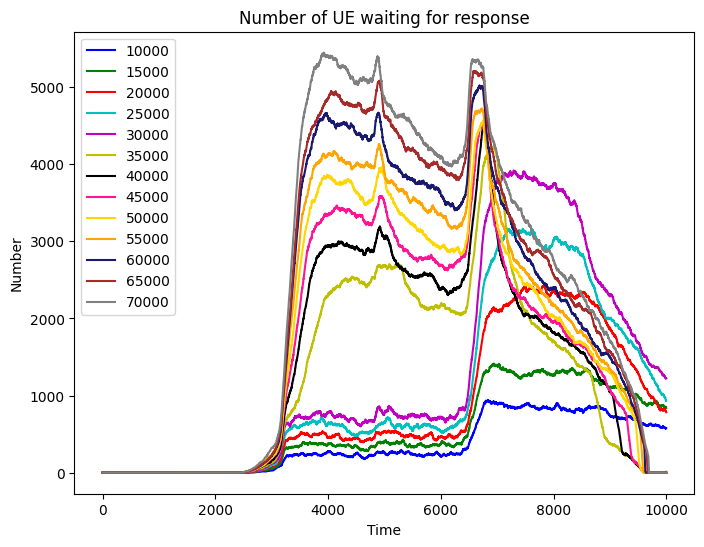

In [87]:
plt.figure(figsize=(8, 6))  # Optional: Set the figure size

# Plot the data
for i in range(len(data)):
    plt.plot(x, data[i].numberUEWaitingResponse, label=label[i], c = color[i])

# Customize the plot (optional)
plt.xlabel('Time')
plt.ylabel('Number')
plt.title('Number of UE waiting for response')
plt.legend()  # Add a legend to distinguish the lines

# Show the plot

plt.savefig('number_UE_waiting_for_response.png', dpi = dpi)

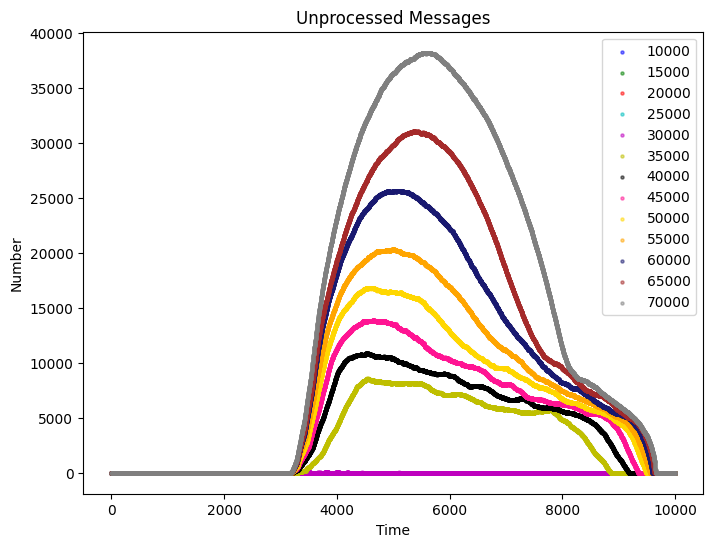

In [88]:
sat_id = 1
plt.figure(figsize=(8, 6))  # Optional: Set the figure size

# Plot the data
for i in range(len(data)):
    plt.scatter(x, data[i].numberUnProcessedMessages[sat_id], label=label[i], c = color[i], s = 5, alpha = 0.5)


# Customize the plot (optional)
plt.xlabel('Time')
plt.ylabel('Number')
plt.title('Unprocessed Messages')
plt.legend()  # Add a legend to distinguish the lines

plt.savefig('number_unprocessed_tasks.png', dpi = dpi)




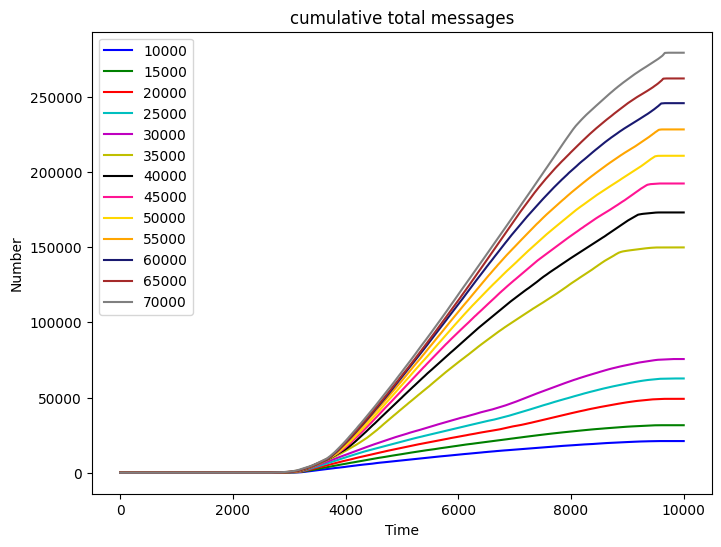

In [6]:
import matplotlib.pyplot as plt
sat_id = 1
plt.figure(figsize=(8, 6))  # Optional: Set the figure size

for i in range(len(data)):
    plt.plot(x, data[i].cumulative_total_messages[sat_id], label=label[i], c = color[i])


# Customize the plot (optional)
plt.xlabel('Time')
plt.ylabel('Number')
plt.title('Cumulative total messages in Satellite 1')
plt.legend()  # Add a legend to distinguish the lines

# Show the plot
plt.show()

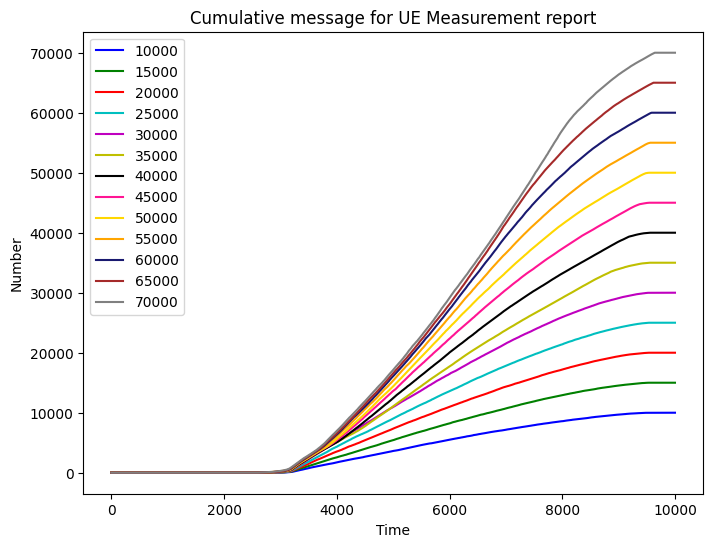

In [7]:
import matplotlib.pyplot as plt
sat_id = 1
plt.figure(figsize=(8, 6))  # Optional: Set the figure size

# Plot the data
for i in range(len(data)):
    plt.plot(x, data[i].cumulative_message_from_UE_measurement[sat_id], label=label[i], c = color[i])

# Customize the plot (optional)
plt.xlabel('Time')
plt.ylabel('Number')
plt.title('Cumulative message in Satellite 1 for UE Measurement report')
plt.legend()  # Add a legend to distinguish the lines

# Show the plot
plt.show()

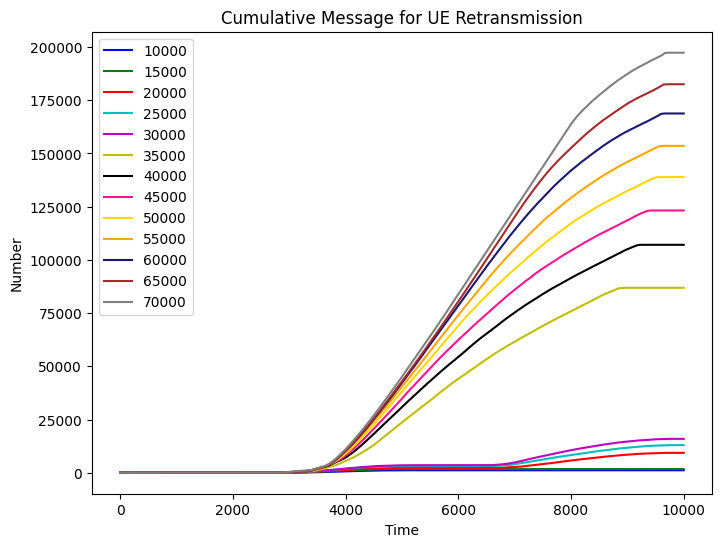

In [8]:
import matplotlib.pyplot as plt
sat_id = 1
plt.figure(figsize=(8, 6))  # Optional: Set the figure size

for i in range(len(data)):
    plt.plot(x, data[i].cumulative_message_from_UE_retransmit[sat_id], label=label[i], c = color[i])

# Customize the plot (optional)
plt.xlabel('Time')
plt.ylabel('Number')
plt.title('Cumulative Message in Satellite 1 for UE Retransmission')
plt.legend()  # Add a legend to distinguish the lines

# Show the plot
plt.show()

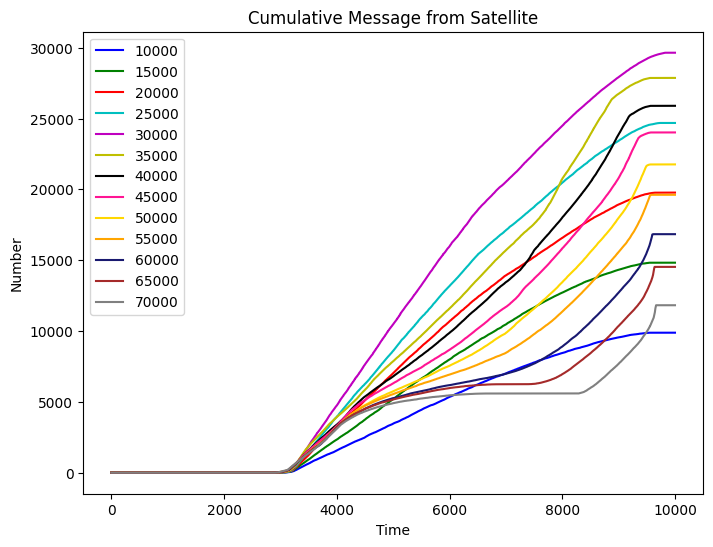

In [9]:
import matplotlib.pyplot as plt
sat_id = 1
plt.figure(figsize=(8, 6))  # Optional: Set the figure size

for i in range(len(data)):
    plt.plot(x, data[i].cumulative_message_from_satellite[sat_id], label=label[i], c = color[i])

# Customize the plot (optional)
plt.xlabel('Time')
plt.ylabel('Number')
plt.title('Cumulative Message in Satellite 1 from Satellite')
plt.legend()  # Add a legend to distinguish the lines

# Show the plot
plt.show()

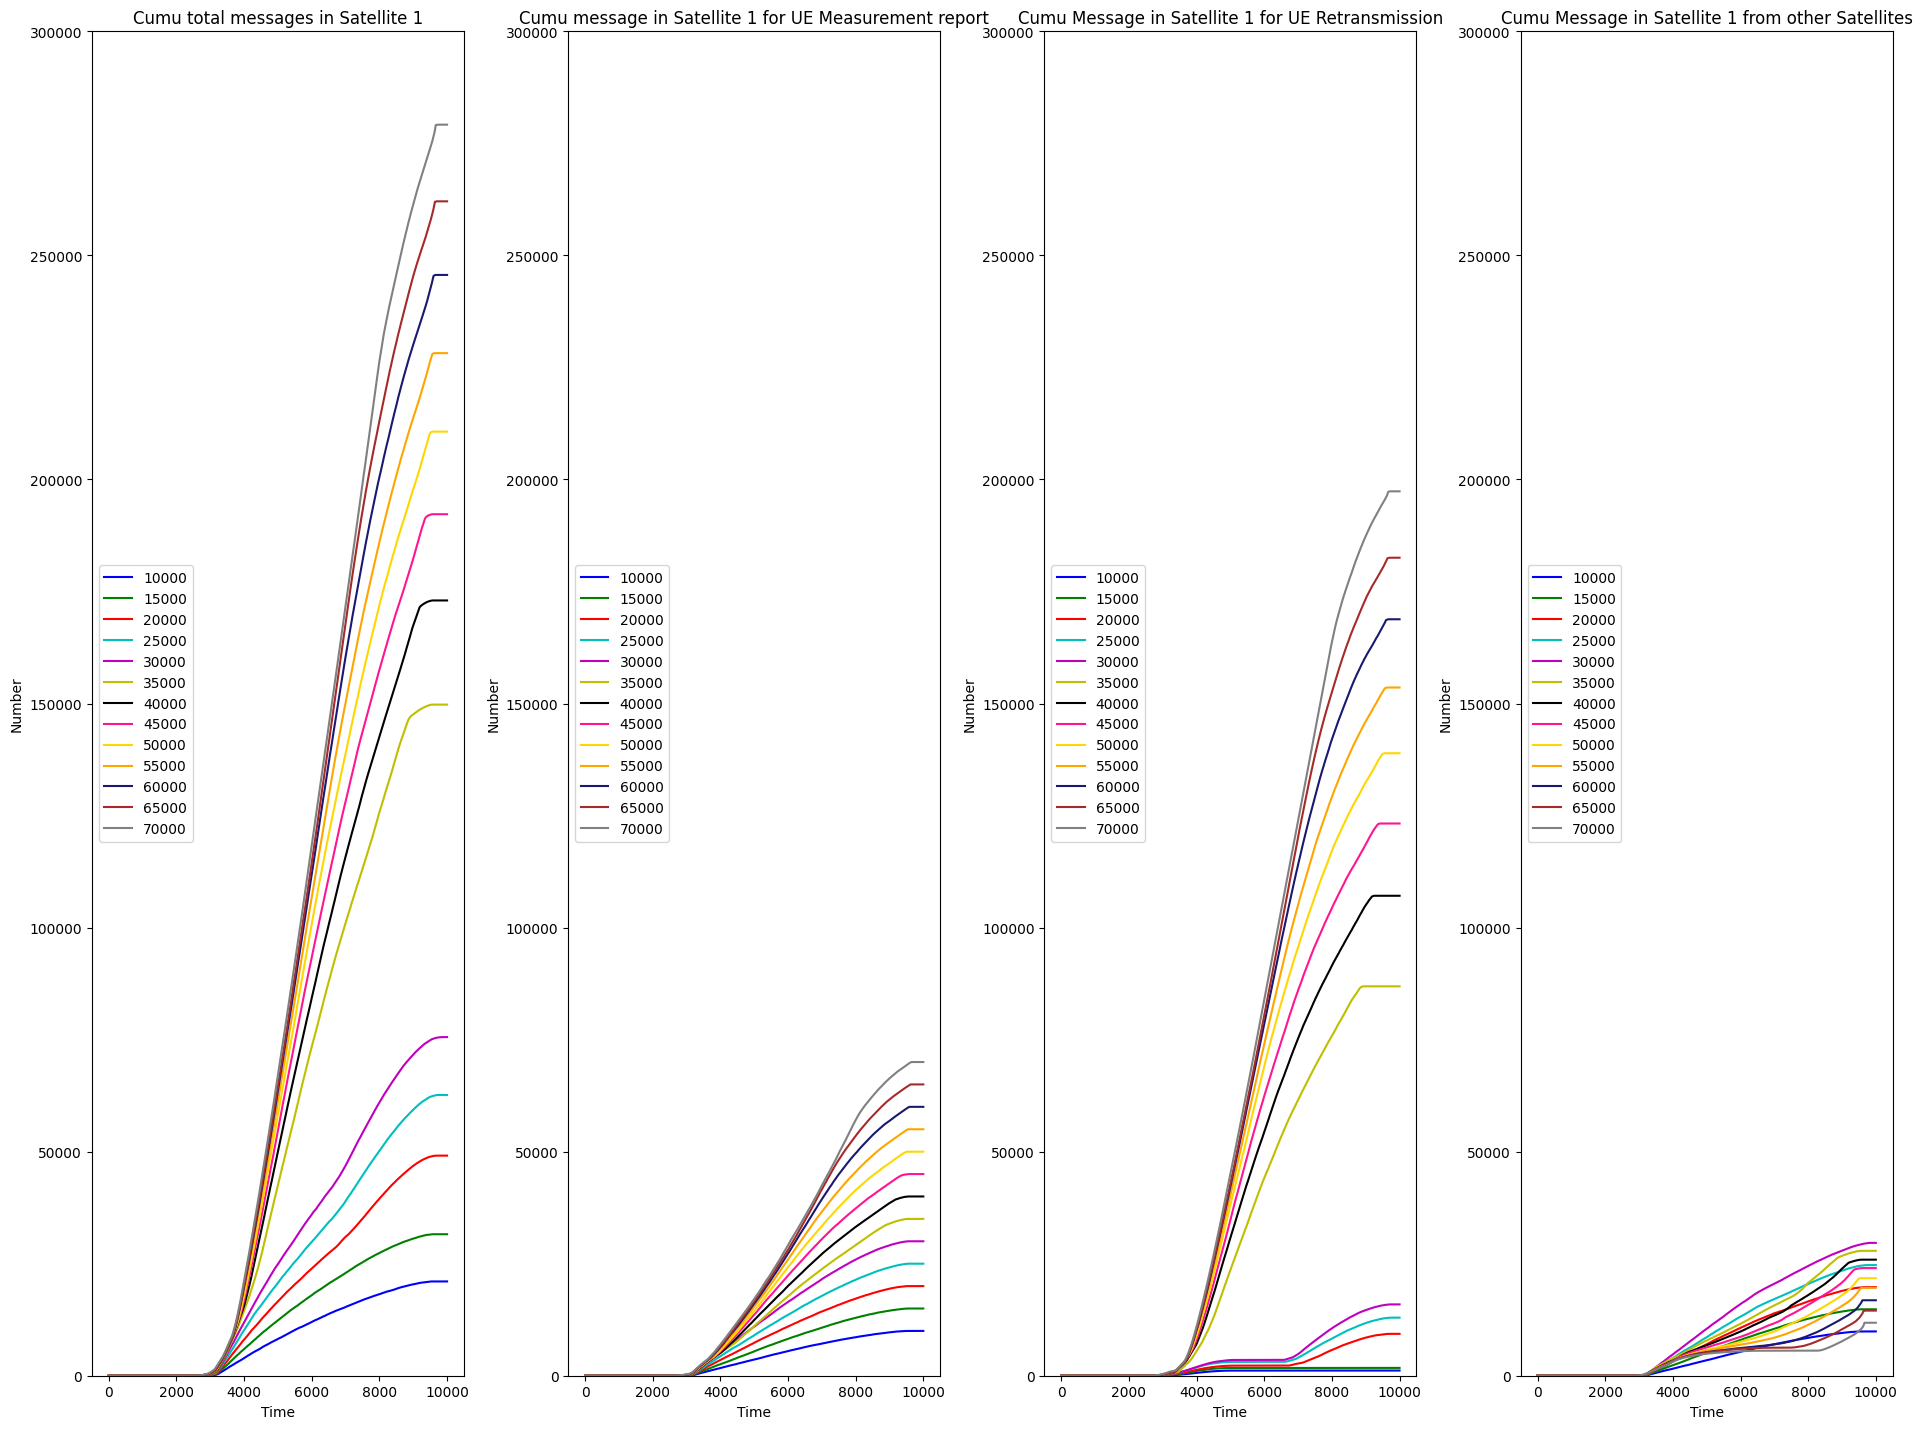

In [79]:
fig, axes = plt.subplots(1, 4, figsize=(24*0.8, 18*0.8))
sat_id = 1

axes[0].set_ylim(0, 300000)
for i in range(len(data)):
    axes[0].plot(x, data[i].cumulative_total_messages[sat_id], label=label[i], c = color[i])
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Number')
axes[0].set_title('Cumu total messages in Satellite 1')
axes[0].legend(loc='center left')  # Add a legend to distinguish the lines

axes[1].set_ylim(0, 300000)
for i in range(len(data)):
    axes[1].plot(x, data[i].cumulative_message_from_UE_measurement[sat_id], label=label[i], c = color[i])

# Customize the plot (optional)
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Number')
axes[1].set_title('Cumu message in Satellite 1 for UE Measurement report')
axes[1].legend(loc='center left')  # Add a legend to distinguish the lines

axes[2].set_ylim(0, 300000)
for i in range(len(data)):
    axes[2].plot(x, data[i].cumulative_message_from_UE_retransmit[sat_id], label=label[i], c = color[i])

# Customize the plot (optional)
axes[2].set_xlabel('Time')
axes[2].set_ylabel('Number')
axes[2].set_title('Cumu Message in Satellite 1 for UE Retransmission')
axes[2].legend(loc='center left')

axes[3].set_ylim(0, 300000)
for i in range(len(data)):
    axes[3].plot(x, data[i].cumulative_message_from_satellite[sat_id], label=label[i], c = color[i])

# Customize the plot (optional)
axes[3].set_xlabel('Time')
axes[3].set_ylabel('Number')
axes[3].set_title('Cumu Message in Satellite 1 from other Satellites')
axes[3].legend(loc='center left')
plt.tight_layout()

dpi = 300
plt.savefig('cumulative_togther.png', dpi = dpi)

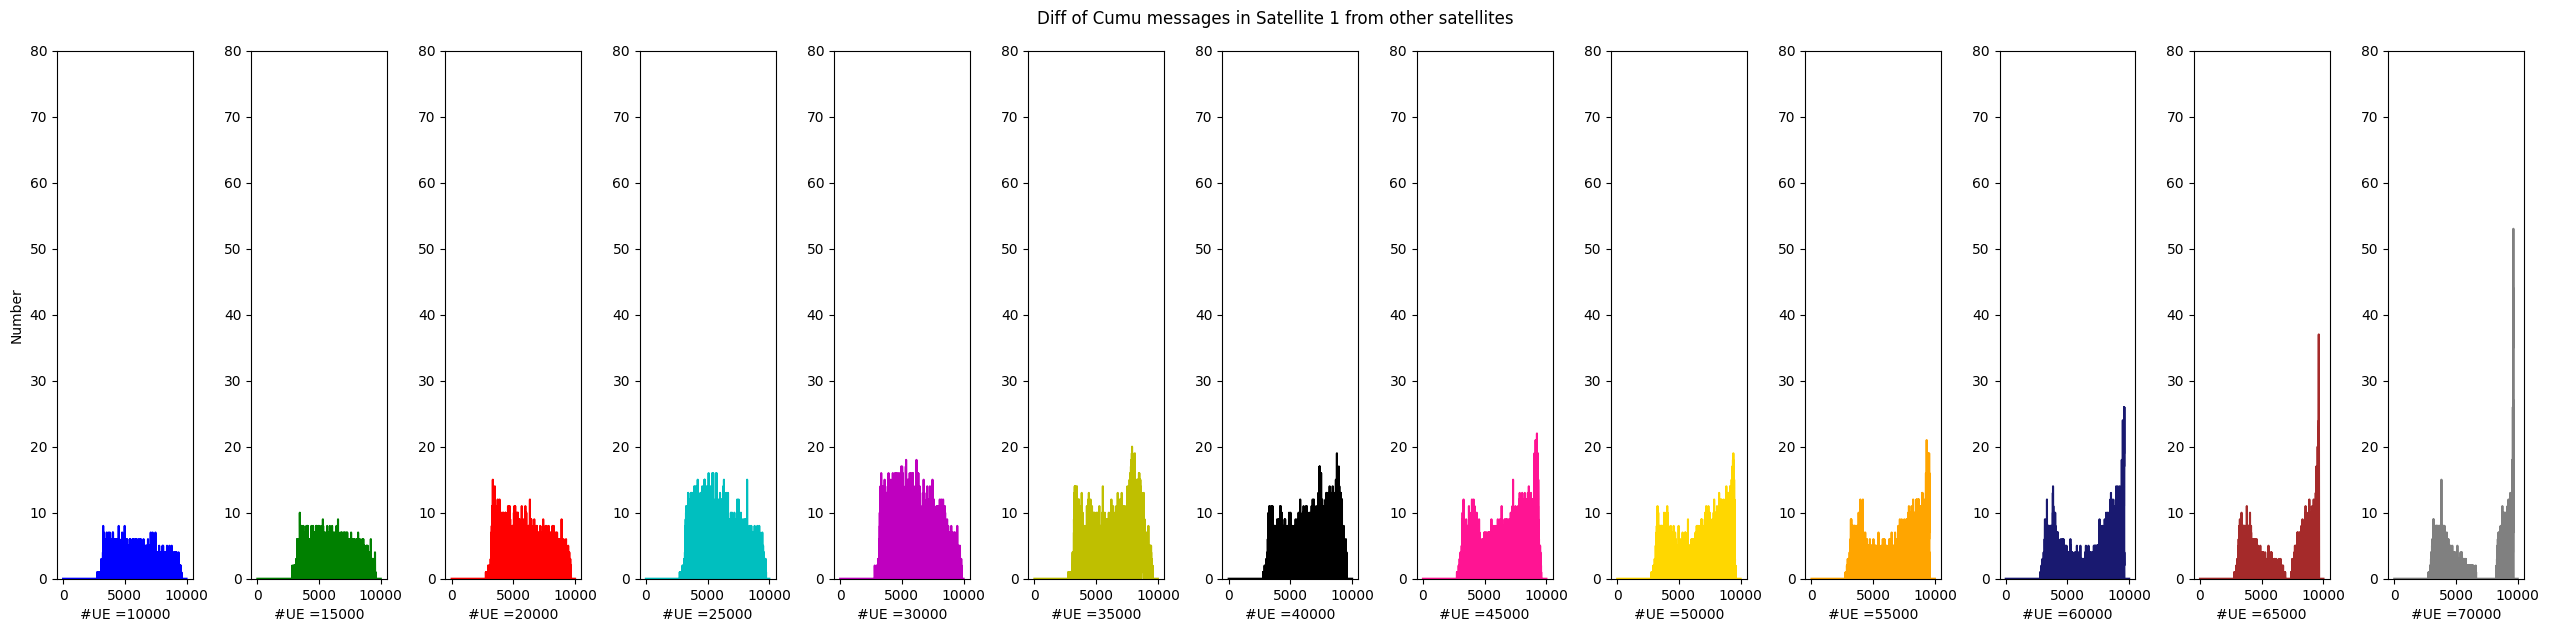

In [85]:
fig, axes = plt.subplots(1, len(data), figsize=(32*0.8, 8*0.8))
sat_id = 1

for i in range(len(data)):
    axes[i].set_ylim(0, 80)
    axes[i].plot(x[1:], np.diff(data[i].cumulative_message_from_satellite[sat_id]), label=label[i], c = color[i])
    axes[i].set_xlabel('#UE =' + str(label[i]))
    axes[0].set_ylabel('Number')
   # axes[0].legend(loc='center left')  # Add a legend to distinguish the lines
fig.suptitle('Diff of Cumu messages in Satellite 1 from other satellites')
# Centered title above subplots
#cumulative_total_messages
#cumulative_message_from_UE_measurement
#cumulative_message_from_UE_retransmit
#cumulative_message_from_satellite

plt.tight_layout()

dpi = 300
plt.savefig('diff_from_other_sat.png', dpi = dpi)